# Nonlinear Regression with Pytorch Modules

This notebook is a modified version of  [Sheet 4.2: Non-linear regression - MLP w/ PyTorch modules](https://michael-franke.github.io/npNLG/04-ANNs/04d-MLP-pytorch.html) by Michael Franke.

In this tutorial, we will fit a non-linear regression, implemented as a multi-layer perceptron.
We will see how the use of modules from PyTorch&rsquo;s neural network package `torch.nn` helps us implement the model efficiently.



## Packages & global parameters



We will need to import the `torch` package for the main functionality.
In order to have a convenient, we will use PyTorch's `DataLoader` and `Dataset` in order to feed our training data to the model.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# set the default theme for Seaborn plots
sns.set_theme()

## True model & training data



The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



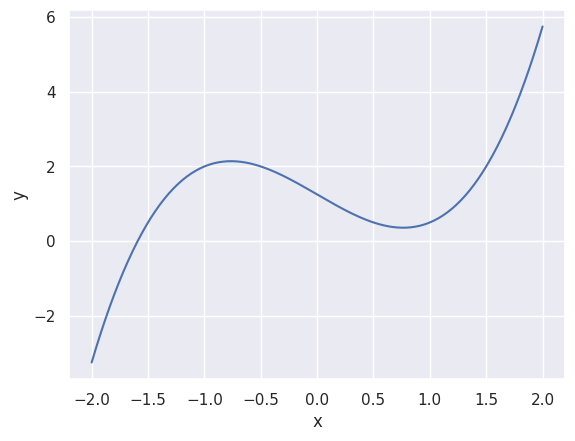

In [ ]:
##################################################
## ground-truth model
##################################################

def goalFun(x):
    return .25*(4 * x**3 - 7 * x + 5 )

# create linear sequence (x) and apply goalFun (y)
x = np.linspace(start = -2, stop =2, num = 200)
y = goalFun(x)

# plot the function
d = pd.DataFrame({'x' : x, 'y' : y})
sns.lineplot(data = d, x = 'x', y = 'y')
plt.show()

The training data consists of 100 pairs of  $(x,y)$ values.
Each pair is generated by first sampling an $x$ value from a uniform distribution.
For each sampled $x$, we compute the value of the target function $f(x)$ and add Gaussian noise to it.



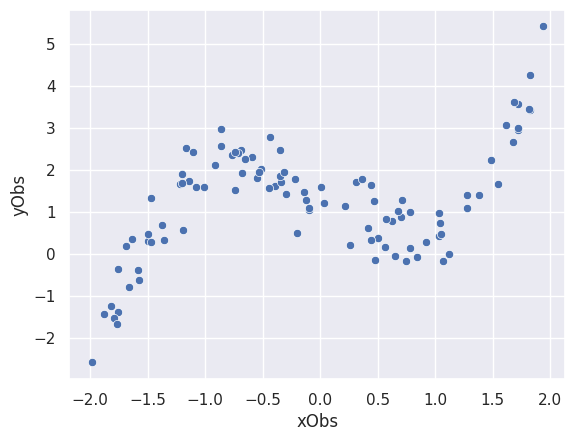

In [ ]:
##################################################
## generate training data (with noise)
##################################################

nObs = 100 # number of observations

torch.manual_seed(42) # reproducibility, remove to experiment

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=0.5) # normal mean 0, std 0.5
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 4*torch.rand([nObs])-2    # uniform from [-2,2]
yObs = goalFun(xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

## Defining the MLP using PyTorch&rsquo;s built-in modules



As before, our model maps a single scalar $x$ onto another scalar $y$.  We use a single layer MLP where the hidden layer has dimension 3:



In [ ]:
##################################################
## network dimension parameters
##################################################

nInput  = 1
nHidden = 3
nOutput = 1

PyTorch defines a special-purpose class called `nn.Module` from which pre-defined neural networks or custom-made networks inherit the structure and basic functionality.
Below, we define our feed-forward neural network as a class extending `nn.Module`.
Minimally, we have to define two functions for this to work:

1.  the **initialization** function `__init__` which defines which parameters and activation functions our model has.
2.  the **forward pass** which takes the model's input and computes the corresponding prediction given the current parameter values.

We'll see two variants which do the same thing.  The first is verbose while the second is more concise but works the same.



### More explicit definition NN module

Note: PyTorch uses object-oriented programming to define and construct neural networks.  If you've never seen OOP in Python here is a [good tutorial from Real Python](https://realpython.com/python3-object-oriented-programming/) to get started.



In [ ]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- explicit version --
##################################################

class MLPexplicit(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super(MLPexplicit, self).__init__()
        self.nInput  = nInput
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.linear1 = nn.Linear(self.nInput, self.nHidden)
        self.linear2 = nn.Linear(self.nHidden, self.nOutput)
        self.ReLU    = nn.ReLU()

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        output = self.linear2(h1)
        return(output)

mlpExplicit = MLPexplicit(nInput, nHidden, nOutput)

We can access the current parameter values of this model instance like so:



In [ ]:
for p in mlpExplicit.parameters():
    print(p.detach().numpy().round(4))

[[ 0.1447]
 [-0.259 ]
 [ 0.4137]]
[-0.3809 -0.6473  0.7299]
[[-0.2625 -0.1157 -0.5744]]
[0.3864]


### **Exercise:** Inspect the model's parameters and their initial values
>
> 1. Make sure that you understand what these parameters are by mapping these onto the parameters of three_relu model from the previous class.
>
> 2. Guess how the weights and biases are initialized (roughly).



### More concise definition of NN module



Here is another, more condensed definition of the same NN model, which uses the \`nn.Sequantial\` function to chain components, thus defining the model parameters and the forward pass in one shot.



In [ ]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- concise version --
##################################################

class MLPconcise(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutput),
        )

    def forward(self, x):
        return(self.layers(x))

mlpConcise = MLPconcise(nInput, nHidden, nOutput)

Here you can select which one to use in the following.



In [ ]:
# which model to use from here onwards
# model = mlpExplicit
model = mlpConcise
model

MLPconcise(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)

## Preparing the training data



Data pre-processing is a tedious but important part of machine learning.  To facilitate a clean interface between the data and the model it helps to have a common format to feed data into any kind of model.

For this purpose, PyTorch provides two data primitives: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.

* The class **Dataset** stores the training data (in a reusable format).
* The class **DataLoader** takes a `dataset` object as input and returns an iterable to enable easy access to the training data.

To define a `Dataset` object, we have to specify three key functions:

1.  the `__init__` function is run once when instatiating the Dataset object and loads our data into the object.  
2.  the `__len__` function reports how many data points there are.
2.  the `__getitem__` function, which takes an index as input and outputs the data point corresponding to that index.



In [ ]:
##################################################
## representing train data as a Dataset object
##################################################

class nonLinearRegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):
        # we're passing in one-dimension tensors, but they should be
        # two-dimensional "column vectors" - not sure this
        # is entirely necessary
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
dset = nonLinearRegressionData(xObs, yObs)

# instantiate DataLoader
#    we use the 4 batches of 25 observations each (full data  has 100 observations)
#    we also shuffle the data
train_dataloader = DataLoader(dset, batch_size=10 , shuffle=True)

We can test the iterable that we create, just to inspect how the data will be delivered later on:



In [ ]:
for i, data in enumerate(train_dataloader, 0):
    input, target = data
    print("In: ", input)
    print("Out:", target,"\n")

In:  tensor([ 0.5033, -1.7915, -1.1973, -0.5503,  1.6769,  0.6754, -0.7381,  1.2784,
        -0.3156,  1.3841])
Out: tensor([ 0.3850, -1.5437,  0.5761,  1.7977,  2.6672,  1.0127,  2.4312,  1.3896,
         1.9458,  1.3995]) 

In:  tensor([ 0.0055, -1.7679,  1.4849,  1.5481,  0.5722,  0.0292,  1.1167,  1.6843,
         1.0325, -0.1980])
Out: tensor([ 1.5795, -1.6748,  2.2306,  1.6586,  0.8364,  1.2044, -0.0133,  3.6138,
         0.4180,  0.4855]) 

In:  tensor([-0.4369, -1.6413, -1.6936, -1.2058, -0.5111, -0.2192, -1.4941,  0.4395,
        -1.4679, -0.3533])
Out: tensor([2.7715, 0.3489, 0.1773, 1.8941, 2.0289, 1.7825, 0.4802, 1.6272, 0.2686,
        1.8525]) 

In:  tensor([ 1.0510, -1.0813,  0.6499,  0.6232,  0.7029, -1.2027,  1.6146, -1.6601,
         1.7179,  1.7188])
Out: tensor([ 0.4731,  1.5775, -0.0527,  0.7827,  0.8650,  1.6766,  3.0637, -0.7993,
         3.5764,  2.9990]) 

In:  tensor([-0.5960, -0.3453,  0.7479,  0.8396, -0.6846,  0.4177, -1.7625,  1.8179,
         1.8219, -0.8

## Training the model



We can now train the model similar to how we did this before.
Note that we need to slightly reshape the input data to have the model compute the batched input correctly.



Loss after epoch   100: 5.714
Loss after epoch   200: 4.188
Loss after epoch   300: 3.115
Loss after epoch   400: 2.413
Loss after epoch   500: 2.002
Loss after epoch   600: 1.736
Loss after epoch   700: 1.567
Loss after epoch   800: 1.453
Loss after epoch   900: 1.436
Loss after epoch  1000: 1.374
Training process has finished.


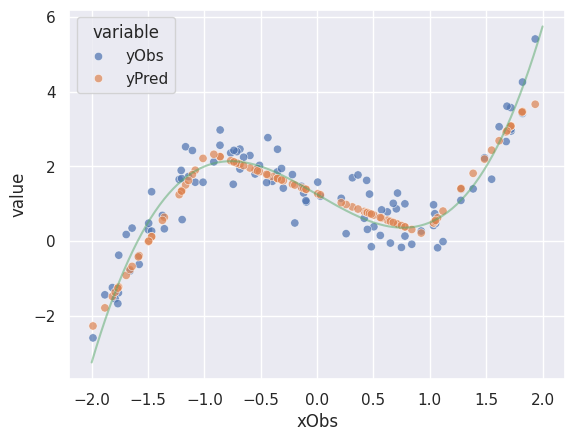

In [ ]:
##################################################
## training the model
##################################################

nTrainSteps = 1000
outputInterval = 100
learningRate = 1e-2
batchSize = 20

# Create a new instance of the model to randomize the weights each time
torch.manual_seed(42) # 47 converges well with lr = 0.01, bs = 20
model = MLPconcise(nInput, nHidden, nOutput)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(dset, batch_size=batchSize, shuffle=True)


# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# Run the training loop
for epoch in range(0, nTrainSteps):

  # Set current loss value
  current_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(train_dataloader):
    # Get inputs
    inputs, targets = data
    # Zero the gradients
    optimizer.zero_grad()
    # Perform forward pass (make sure to supply the input in the right way)
    outputs = model(torch.reshape(inputs, (len(inputs), 1))).squeeze()
    # Compute loss
    loss = loss_function(outputs, targets)
    # Perform backward pass
    loss.backward()
    # Perform optimization
    optimizer.step()
    # Print statistics
    current_loss += loss.item()

  if (epoch + 1) % outputInterval == 0:
      print('Loss after epoch %5d: %.3f' %
            (epoch + 1, current_loss))
      current_loss = 0.0

# Process is complete.
print('Training process has finished.')

yPred = np.array([model.forward(torch.tensor([o])).detach().numpy() for o in xObs]).flatten()

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -2, stop =2, num = 200)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise: Explore the model&rsquo;s behavior</span></strong>
>
> 0. [Just for yourself.] Make sure you understand *every line* in this last code block. Ask if anything is unclear.
>
> 1. Above we used the DataLoader to train in 4 mini-batches. Change it so that there is only one batch containing all the data. Change the \`shuffle\` parameter so that data is not shuffled. Run the model and check if you observe any notable differences. Explain what your observations. (If you do not see anything, explain why you don&rsquo;t. You might pay attention to the results of training)



Sometimes the optimization gets stuck in local minima that result in models that perform poorly.  This seems to happen less with more complex models (more layers) and smaller batch sizes.  There are also enhancements to gradient descent that can help avoid some local minima.



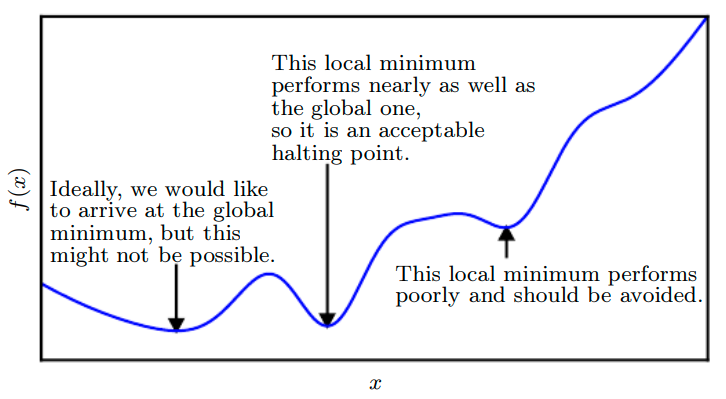

## Some Gradient Descent Nomenclature

Some authors use **batch** to refer to the entire dataset and **mini-batch** to refer subsets of the dataset as in the picture below.  

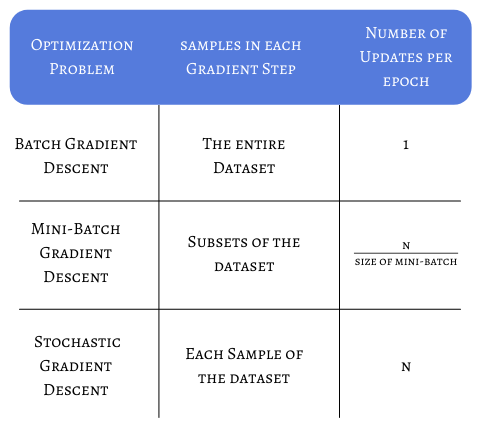

In PyTorch the convention seems to be that a batch is a subset of the entire dataset.  PyTorch uses one optimizer, `SGD` or Stochastic Gradient Descent, to cover all the variations of gradient descent in the image above.  The only thing we need to change is the batch size in the dataloader.  Pytorch models handle all of the batching for us and apply the model to each input data in the batch.